<a href="https://colab.research.google.com/github/PippleNL/Lecture-Time-Series/blob/main/Pipple_Lecture_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting 
The goal of this notebook is to get the user acquainted with time series forecasting by using (S)ARIMA models to predict future values of a time series. Users who are already comfortable with this subject matter can try to implement different types of time series modelling to investigate if these models can achieve higher accuracy on the given time series.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 5.0 MB/s 
     |████████████████████████████████| 9.8 MB 41.0 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from pmdarima.datasets import load_wineind
df = load_wineind(True)
df= df.reset_index()
df.columns = ['Period', 'Sales_quantity']
df['Period_date'] = pd.to_datetime(df['Period'])
ts = df.set_index('Period_date')['Sales_quantity']
len_train = round(len(ts)*0.8)
ts_test = ts[len_train:] # Create test and train set
ts = ts[:len_train]

For this excerise, we will use the sales of Company X over a time frame of approximately 5 years as a data set, which can be seen in a plot by running the code below.

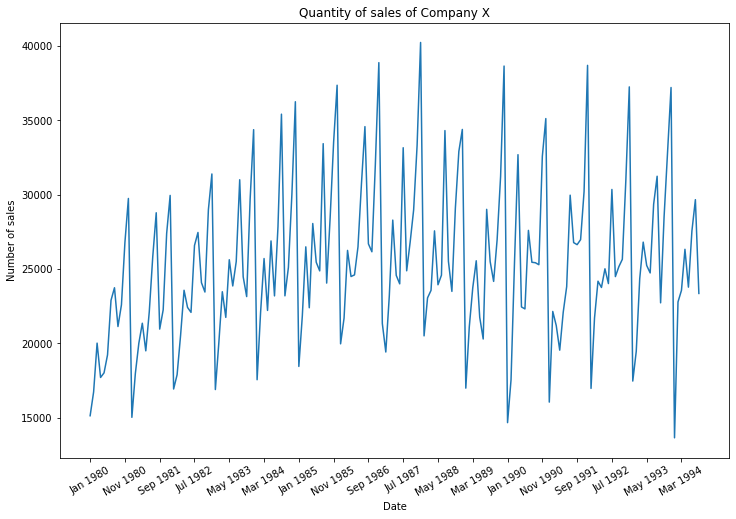

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.xticks(np.arange(0,df.shape[0]+1,10),rotation=30)
plt.plot(df.set_index('Period')['Sales_quantity'])
plt.xlabel('Date')
plt.ylabel('Number of sales')
plt.title('Quantity of sales of Company X')
plt.show()

## Time series decomposition
When tackling time series problems by using (S)ARIMA models, it is useful to think of each time series as being a combination of the following 4 components:
* **Level**: The average value in the series
* **Trend**: The increasing or decreasing value in the series
* **Seasonality**: The repeating short-term cycle in the series
* **Noise**: The random variation in the series

These 4 components can be combined in two ways:
- **Additive**: ```
y(t) = Level + Trend + Seasonality + Noise
```
- **Multiplicative**: ```y(t) = Level * Trend * Seasonality * Noise ```

In the below code, we can decompose the time series of Company X into the four components, however, we still have to determine whether we want a multiplicative or additive combination.


---

*A rule of thumb for selecting the right model is to see in the sales data plot if the trend and seasonal variation are relatively constant over time, in other words, linear. If yes, then we will select the Additive model. Otherwise, if the trend and seasonal variation increase or decrease over time then we use the Multiplicative model.*


---




Text(0, 0.5, 'Residuals')

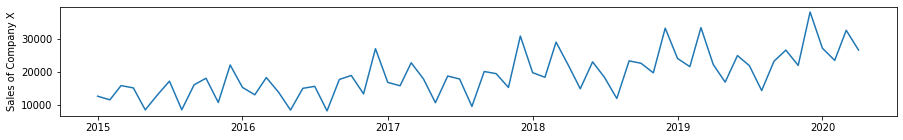

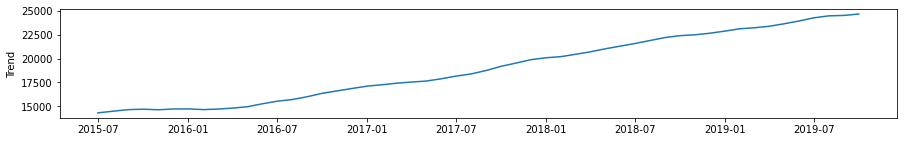

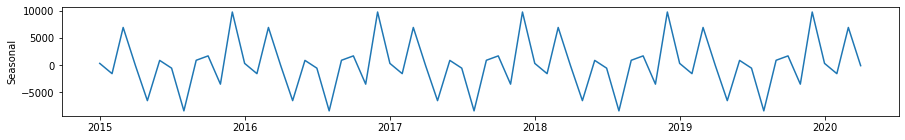

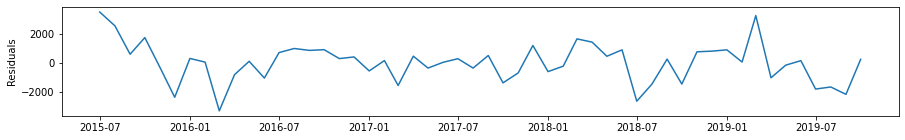

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, model= 'additive') ## Choose your model
plt.figure(figsize=(15,2))
plt.plot(decomposition.observed)
plt.ylabel('Sales of Company X')
plt.figure(figsize=(15,2))
plt.plot(decomposition.trend)
plt.ylabel('Trend')
plt.figure(figsize=(15,2))
plt.plot(decomposition.seasonal)
plt.ylabel('Seasonal')
plt.figure(figsize=(15,2))
plt.plot(decomposition.resid)
plt.ylabel('Residuals')

Decomposition is a useful tool to visualize your data and inspect it, however it does not directly provide a way to make time series forecasts. 
Instead, use it as a way to get a grasp of the trend and seasonality of your data and get a feeling for what might be important to include in the model you are building.

## Models
When inspecting the sales data of Company X and the decomposition plot, it becomes clear that we are dealing with seasonal data with an upwards trend. Typically when tackling this kind of problem, one would use a ```SARIMA(p,d,q)(P,D,Q)m``` model.
 However, a SARIMA model actually consists of 4 different components, which we will discuss separately and later combine to form a SARIMA model.  The four components of SARIMA are as follows:

- **S(P,D,Q)m** -> Seasonal
- **AR(p)** -> Auto Regressive 
- **I(d)** -> Integrated 
- **MA(q)** -> Moving Average


---



### Component 1: I(d) &rarr; Integrated
We start by discussing the *integrated* part of SARIMA as this part is responsible for creating a stationary series which is crucial for a SARIMA model.

In the most intuitive sense, stationarity means that the statistical properties of a process generating a time series do not change over time. It does not mean that the series does not change over time, just that the way it changes does not itself change over time. The algebraic equivalent is thus a linear function, perhaps, and not a constant one; the value of a linear function changes as 𝒙 grows, but the way it changes remains constant — it has a constant slope; one value that captures that rate of change.

One can do a first inspection of stationarity by looking at the time series and use the following rules to determine that a series is not stationary:
- Prominent seasonality can be observed
- Noticeable trends and changing levels can be seen
- Series (i) shows increasing variance.

**Exercise 1: Determine which of the series in the following graph are stationary**

(Answers can be found at the bottom of the notebook.)

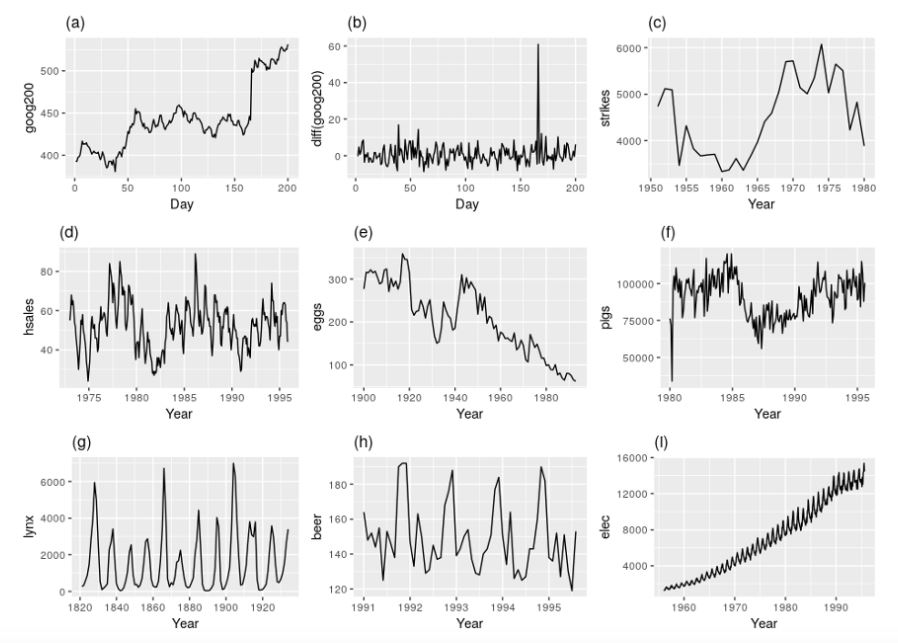




Above mentioned method, to determine stationarity just by looking at the time series, is a bit shady, and prone to errors. However, when it comes to SARIMA models, having a stationary time series is crucial since the auto regressive (AR) part of SARIMA means it is a linear regression that uses its own lags as predictors. Linear regressions work best when the predictors are not correlated and are independent of each other -> thus stationarity is a must.

Therefore we introduce 2 more trustable methods to determine stationarity:

**Method 1. Looking at Autocorrelation Function (ACF) plots**

Autocorrelation is the correlation of a signal with a delayed copy — or a lag — of itself as a function of the delay. When plotting the value of the ACF for increasing lags (a plot called a correlogram), the values tend to degrade to zero quickly for stationary time series (see figure, right), while for non-stationary data the degradation will happen more slowly (see figure, left)
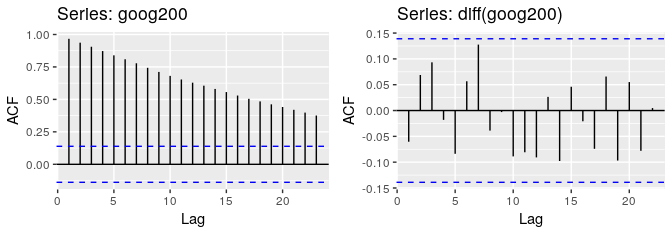

The correlogram can be used to determine the order of differencing needed to make a series stationary. (Differencing is performed by subtracting the previous observation from the current observation: ```difference(t)=observation(t)-observation(t-1)```
By differencing the differenced time series, you create a second order differenced time series.

Rules of thumb when determining the required order of differencing:
- If autocorrelations are positive for many numbers of lags (>10) -> More differencing
- If autocorrelation lag 1 is too negative -> Less differencing
- Can't decide -> Go with the order that gives the smallest standard deviation in the differenced series.

**Exercise 2: Determine required order of differencing of sales of Company X by using correlogram**

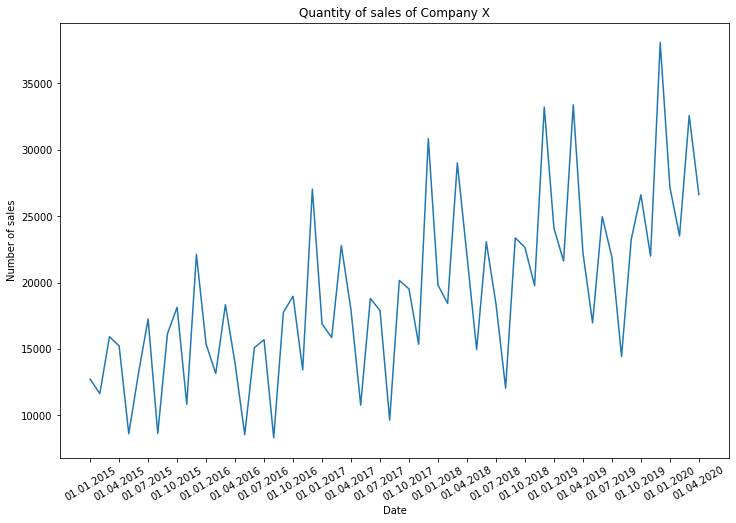

In [ ]:
fig, ax = plt.subplots(figsize=(12,8))
plt.xticks(np.arange(0,df.shape[0]+1,3),rotation=30)
plt.plot(df.set_index('Period')['Sales_quantity'])
plt.xlabel('Date')
plt.ylabel('Number of sales')
plt.title('Quantity of sales of Company X')
plt.show()

In [ ]:
## Exercise 2:
# Plot ACF plot

# Determine whether differencing is needed -> If so, plot ACF of differenced series

# If needed repeat above step

# Plot final differenced timeseries for visual inspection

**Method 2: Augmented Dickey Fuller test**

After checking the ACF plot, the ADF test is performed as another check if the chosen order of differencing is correct. The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then you reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if P Value > 0.05, the time series is not yet stationary, and it needs differencing. The same test can then be applied on the differenced time series to test if this time series is differenced.

**Exercise 3: Perform ADF test to determine order of differencing**

In [ ]:
from statsmodels.tsa.stattools import adfuller
## Exercise 3:
# Perform ADF test

Combine your findings from the ACF plot and the ADF test to decide on the order of differencing you want to use. By doing so, you have selected the first hyperparameter of your SARIMA model, i.e. the *d* hyperparameter.


---


### Component 2: AR(P) &rarr; Auto Regressive
A pure Auto Regressive (AR only) model is one where Yt depends only on its own lags. That is, Yt is a function of the ‘lags of Yt’. 
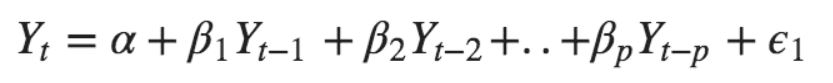

where, $Y{t-1}$ is the lag1 of the series, $\beta1$ is the coefficient of lag1 that the model estimates and $\alpha$ is the intercept term, also estimated by the model.

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

But what is PACF?

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not. Any autocorrelation in a stationarized series can be rectified by adding enough AR terms. So, we initially take the order of AR term to be equal to the first AR term for which the autocorrelation is below the significance level in the PACF plot, minus 1. (Note that the partial autocorrelation for AR term 0 will always be 1 as a time series is obviously correlated with its non-lagged counterpart, which is just the series itself. AR term 0 is depicted in the PACF plot by the left most bar.) 
How the significance level in the PACF plot is determined is beyond the scope of this lecture.

**Exercise 4: Determine the correct AR term by using the PACF plot**
(Use the Yule-Walker without adjustment method)

In [ ]:
# Plot PACF plot for the sales of Company X
# (Values should be between -1 and 1)

By choosing the AR term, you have selected the *p* hyperparameter for you SARIMA model! 


---

### Component 3: MA(q) &rarr; Moving Average

A pure Moving Average (MA only) model is one where Yt depends only on the lagged forecast errors.
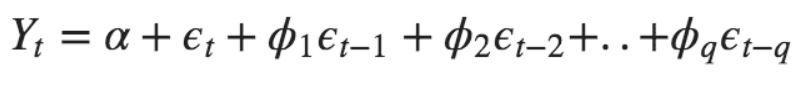

where the error terms are the errors of the autoregressive models of the respective lags. The errors Et and E(t-1) are the errors from the following equations :

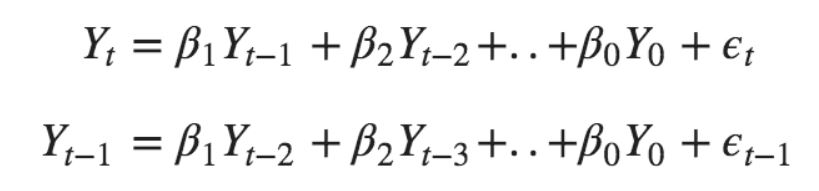

Just like how we looked at the PACF plot for the number of AR terms, you can look at the ACF plot of the differenced time series for the number of MA terms. An MA term is technically, the error of the lagged forecast. The ACF tells how many MA terms are required to remove any autocorrelation in the stationarized series.

(Remember that we also looked at ACF plots when determining the order of differencing!)

**Exercise 5: Determine the correct AR term by using the ACF plot**

In [ ]:
# Plot ACF plot for the sales of Company X
# Remember to use the order of differencing you have chosen earlier




---
### Combining components &rarr; ARIMA
An ARIMA model is one where the time series was differenced at least once to make it stationary and you combine the AR and the MA terms. So the equation becomes:

*ARIMA model in words:*

Predicted Yt = Constant + Linear combination Lags of Y (upto p lags) + Linear Combination of Lagged forecast errors (upto q lags)

Before adding the seasonal component, we will first act as if it does not exist, thus creating an ARIMA model.

**Exercise 6: Create ARIMA model by using your hyperparameters**

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(ts, order=(p,d,q)) # Fill in your own p,d,q
model = arima_model.fit()
print(model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         Sales_quantity   No. Observations:                   64
Model:                 ARIMA(1, 1, 3)   Log Likelihood                -623.530
Date:                Wed, 08 Jun 2022   AIC                           1257.060
Time:                        12:29:58   BIC                           1267.776
Sample:                    01-01-2015   HQIC                          1261.275
                         - 04-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3361      0.204     -1.645      0.100      -0.736       0.064
ma.L1         -0.3175      0.170     -1.872      0.061      -0.650       0.015
ma.L2         -0.1313      0.141     -0.934      0.3

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


As seen above, the model summary provides several statistical measures to evaluate the performance of our model. Moreover, we also know the coefficient values for each of the parameters. By looking at the p-values per coefficient, you can check whether a coefficient is significant or not.

Other than that we see the scores such as Akaike Information Critera (AIC), Bayesian Information Criterion (BIC), Hannan-Quinn Information Criterion (HQIC), and the standard deviation of innovations (innovations are the difference of the real value at time t and the predicted value at that time).

The Akaike Information Critera or AIC is a good measure for testing the goodness of how fit the model is mathematically. Information Criteria scores measure the amount of information lost by training and generalizing the ARIMA model. The AIC must be as low as possible. 



---

### Combining components &rarr; Auto ARIMA
Even though it is good to understand the logic behind choosing ARIMA parameters, it is not necessary to choose them yourself everytime you want to use time series forecasting. Python already offers the possibility to run an automatic ARIMA model which selects the optimal parameters for you.

**Exercise 7: Create an Auto-ARIMA model**
(Do not yet use a seasonal component.)


In [ ]:
# Create auto arima model.

In [ ]:
from pmdarima.arima import auto_arima

auto_arima = auto_arima(ts, start_p= 0, seasonal=False, start_q=0)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  176
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1746.125
Date:                Wed, 08 Jun 2022   AIC                           3500.251
Time:                        15:26:51   BIC                           3512.910
Sample:                             0   HQIC                          3505.386
                                - 176                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1420      0.109      1.307      0.191      -0.071       0.355
ar.L2         -0.2572      0.125     -2.063      0.039      -0.502      -0.013
ma.L1         -0.9074      0.052    -17.526      0.000      -1.009      -0.806
sigma2      2.912e+07   1.19e-09   2.44e+16      0.000    2.91e+07    2.91e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.92   Prob(JB):                         0.79
Heteroskedasticity (H):               1.37   Skew:                            -0.12
Prob(H) (two-sided):                  0.23   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.7e+32. Standard errors may be unstable.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   64
Model:               SARIMAX(5, 1, 2)   Log Likelihood                -603.889
Date:                Wed, 08 Jun 2022   AIC                           1225.778
Time:                        13:01:00   BIC                           1245.067
Sample:                             0   HQIC                          1233.365
                                 - 64                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    369.9814    125.636      2.945      0.003     123.740     616.223
ar.L1          0.0493      0.380      0.130      0.897      -0.696       0.795
ar.L2          0.0774      0.226      0.343      0.732      -0.365       0.520
ar.L3          0.4303      0.119      3.613      0.000       0.197       0.664
ar.L4         -0.5101      0.207     -2.459      0.014      -0.917      -0.103
ar.L5         -0.4659      0.262     -1.780      0.075      -0.979       0.047
ma.L1         -0.9749      0.492     -1.982      0.047      -1.939      -0.011
ma.L2          0.0358      0.468      0.076      0.939      -0.881       0.952
sigma2      1.283e+07      0.002   7.63e+09      0.000    1.28e+07    1.28e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.89
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               0.79   Skew:                             0.48
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.01e+25. Standard errors may be unstable.
"""



---

### Combining components &rarr; SARIMA

## Forecasting
When you have decided on your model, it is time to 

# Answers to exercises

**Exercise 1:**
- Prominent seasonality can be observed in series (d), (g), (h) and (i).
- Noticeable trends and changing levels can be seen in series (a), (c), (e), (f), and (i).
- Series (i) shows increasing variance.

This leaves series (b) as the only stationary series.

**Exercise 2:**(d)

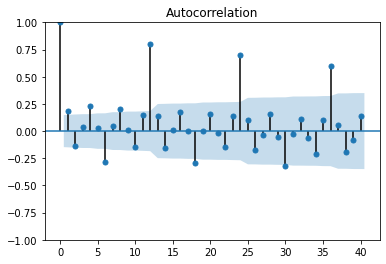

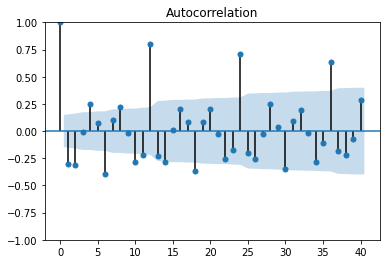

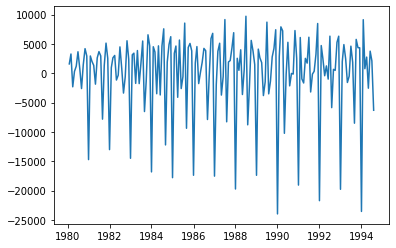

In [ ]:
import statsmodels.api as sm
# Plot ACF plot
sm.graphics.tsa.plot_acf(ts, lags=40)
plt.show()

# Determine whether differencing is needed -> If so, plot ACF of differenced series
first_diff = ts.diff()[1:]
sm.graphics.tsa.plot_acf(first_diff, lags=40)
plt.show()

# Plot final differenced timeseries for visual inspection

plt.plot(first_diff)

**Exercise 3:**

In [ ]:
from statsmodels.tsa.stattools import adfuller
# Non differenced ADF test
result = adfuller(ts)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# First-order differenced ADF test
first_diff = ts.diff()[1:]
result = adfuller(first_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# Second-order differenced ADF test
second_diff = first_diff.diff()[1:]
result = adfuller(second_diff)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.852468
p-value: 0.051161
ADF Statistic: -23.414234
p-value: 0.000000
ADF Statistic: -10.094060
p-value: 0.000000


**Exercise 4:**(p)

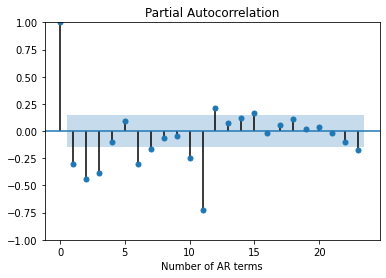

In [ ]:
# Plot PACF plot for the sales of Company X
sm.graphics.tsa.plot_pacf(first_diff, method='ywm')
plt.xlabel("Number of AR terms")
plt.show()

**Exercise 5:**(q)

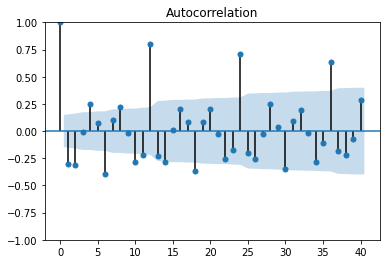

In [ ]:
# Plot ACF plot for the sales of Company X
# Remember to use the order of differencing you have chosen earlier

sm.graphics.tsa.plot_acf(first_diff, lags=40)
plt.show()

**Exercise 6:**


In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(ts, order=(3,1,2)) # Fill in your own p,d,q
model = arima_model.fit()
print(model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  176
Model:                 ARIMA(3, 1, 2)   Log Likelihood               -1746.113
Date:                Wed, 08 Jun 2022   AIC                           3504.226
Time:                        13:54:26   BIC                           3523.215
Sample:                    01-01-1980   HQIC                          3511.928
                         - 08-01-1994                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2941      2.482     -0.118      0.906      -5.159       4.571
ar.L2         -0.1962      0.375     -0.524      0.600      -0.931       0.538
ar.L3         -0.1415      0.600     -0.236      0.8

In [ ]:
from pmdarima.arima import auto_arima

auto_arima = auto_arima(ts, start_p= 0, seasonal=False, start_q=0)
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  176
Model:               SARIMAX(2, 1, 1)   Log Likelihood               -1746.125
Date:                Wed, 08 Jun 2022   AIC                           3500.251
Time:                        13:55:07   BIC                           3512.910
Sample:                             0   HQIC                          3505.386
                                - 176                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1420      0.109      1.307      0.191      -0.071       0.355
ar.L2         -0.2572      0.125     -2.063      0.039      -0.502      -0.013
ma.L1         -0.9074      0.052    -17.526      0.000      -1.009      -0.806
sigma2      2.912e+07   1.19e-09   2.44e+16      0.000    2.91e+07    2.91e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.48
Prob(Q):                              0.92   Prob(JB):                         0.79
Heteroskedasticity (H):               1.37   Skew:                            -0.12
Prob(H) (two-sided):                  0.23   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.7e+32. Standard errors may be unstable.
"""

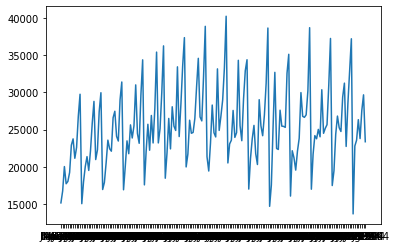

In [ ]:
ts

index_date
1980-01-01    15136.0
1980-02-01    16733.0
1980-03-01    20016.0
1980-04-01    17708.0
1980-05-01    18019.0
               ...   
1994-04-01    26323.0
1994-05-01    23779.0
1994-06-01    27549.0
1994-07-01    29660.0
1994-08-01    23356.0
Name: Sales, Length: 176, dtype: float64